**Setting Up Google Colab and Mounting Google Drive**



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Extracting .rar Files in Colab**

1.   Install the unrar tool to handle .rar files in Colab.
2.   Extract the dataset. Move your .rar files to your Google Drive and specify the file path to extract them. Replace "your_dataset.rar" with the actual filename in your Drive.

This will extract the files into a directory named /content/dataset/. Now, you should have subfolders like COVID-19, Pneumonia, and Normal, depending on the dataset structure.



In [7]:
# Install unrar to handle .rar files
!apt-get install unrar


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


**Flatten the Directory Structure After Extraction**

We’ll modify the extraction process to automatically move images from the nested folders to a single-level structure. Here’s how you can do it:

In [8]:
import os
import shutil

# Paths to the .rar files
covid_rar = '/content/drive/MyDrive/PROJECT_HDA/data/covid.rar'
normal_rar = '/content/drive/MyDrive/PROJECT_HDA/data/normal.rar'
pneumonia_rar = '/content/drive/MyDrive/PROJECT_HDA/data/pneumonia.rar'

# Define the target directories for each class
target_dirs = {
    'covid': '/content/dataset/covid',
    'normal': '/content/dataset/normal',
    'pneumonia': '/content/dataset/pneumonia'
}

# Ensure target directories exist
for dir_path in target_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

# Step 1: Extract each .rar file into a temporary directory
temp_extract_dir = '/content/temp_extract/'  # Temporary directory for nested extraction
os.makedirs(temp_extract_dir, exist_ok=True)

# Extract and flatten each .rar file
!unrar x {covid_rar} {temp_extract_dir}
!unrar x {normal_rar} {temp_extract_dir}
!unrar x {pneumonia_rar} {temp_extract_dir}

# Step 2: Move images from nested folders to the correct target directories
for cls, target_dir in target_dirs.items():
    cls_temp_dir = os.path.join(temp_extract_dir, cls)  # Navigate to nested directory

    # Walk through all subdirectories and find image files
    for root, _, files in os.walk(cls_temp_dir):
        for file in files:
            # Only move image files (e.g., .jpg, .jpeg, .png)
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                # Move each image to the target directory for its class
                shutil.move(os.path.join(root, file), os.path.join(target_dir, file))

print("Extraction and directory flattening complete.")



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/PROJECT_HDA/data/covid.rar

Creating    /content/temp_extract/covid                               OK
Extracting  /content/temp_extract/covid/01E392EE-69F9-4E33-BFCE-E5C968654078-768x572.jpeg       0%  OK 
Extracting  /content/temp_extract/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C-1068x1083.jpeg       0%  OK 
Extracting  /content/temp_extract/covid/0C7E78DA-FAFC-480D-88B6-1459C51481AF-1068x817.jpeg       0%  OK 
Extracting  /content/temp_extract/covid/1312A392-67A3-4EBF-9319-810CF6DA5EF6-1068x1086.jpeg       0%  OK 
Extracting  /content/temp_extract/covid/134895D3-77B8-4546-B7E5-C7DABD600309-1068x911.jpeg       0%  OK 
Extracting  /content/temp_extract/covid/1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D-768x635.jpeg       0%  OK 
Extracting  /content/temp_extract/covid/1F6343EE-AFEC-4B7D-97F5-62797EE18767-1068x1064.jpeg     

In [9]:
import os

# List the extracted files in each folder
print("COVID files:", os.listdir('/content/dataset/covid')[:5])  # Show first 5 files
print("Normal files:", os.listdir('/content/dataset/normal')[:5])
print("Pneumonia files:", os.listdir('/content/dataset/pneumonia')[:5])


COVID files: ['COVID19(557).jpg', 'COVID-19 (104).jpg', 'COVID19(101).jpg', 'COVID19(62).jpg', 'COVID-19 (684).jpg']
Normal files: ['00000169_001.png', '00001004_002.png', '00000461_001.png', '00000186_000.png', '00000315_000.png']
Pneumonia files: ['person1695_bacteria_4492.jpeg', 'person1912_bacteria_4817.jpeg', 'person570_virus_1112.jpeg', 'person1062_virus_1762.jpeg', 'person1545_bacteria_4042.jpeg']


**Environment Setup and Dataset Preparation**

Set up the basic imports for model building, data loading, and visualization.

In [10]:
#required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

**Create Train/Test Split**

We’ll create a train and test split programmatically:

Set up separate train and test folders, create a structure for the train and test sets, with 80% of the images in train and 20% in test.

Copy a portion of images from each class folder into the new train and test folders.We’ll use shutil to copy files into new directories.

After running this code, your directory structure should look like this:

/content/dataset_split/

├── train/
│   ├── covid/
│   ├── normal/
│   └── pneumonia/

└── test/
    ├── covid/
    ├── normal/
    └── pneumonia/

In [11]:
import os
import random
import shutil

# # Define paths for the train and test split
data_dir = "/content/dataset"
train_dir = "/content/dataset_split/train"
test_dir = "/content/dataset_split/test"

# Define the class names
classes = ['covid', 'normal', 'pneumonia']

# Define the split ratio
train_ratio = 0.8

# Create train and test directories for each class/ Loop over each class folder to split images
for cls in classes:
# Create the class directories in train and test folders
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

# Source folder for each class
    cls_folder = os.path.join(data_dir, cls)
#    cls_folder = f"/content/dataset/{cls}"
    print(f"Contents of {cls_folder}:")
    print(os.listdir(cls_folder))

    # Get list of images in each class folder
    images = [img for img in os.listdir(cls_folder) if os.path.isfile(os.path.join(cls_folder, img))]

    # Shuffle images and split based on train_ratio
    random.shuffle(images)
    split_idx = int(len(images) * train_ratio)
    train_images = images[:split_idx]
    test_images = images[split_idx:]

    # Copy images to the respective train and test directories
    for img in train_images:
        shutil.copy(os.path.join(cls_folder, img), os.path.join(train_dir, cls, img))
    for img in test_images:
        shutil.copy(os.path.join(cls_folder, img), os.path.join(test_dir, cls, img))

print("Dataset split and organization complete.")

Contents of /content/dataset/covid:
['COVID19(557).jpg', 'COVID-19 (104).jpg', 'COVID19(101).jpg', 'COVID19(62).jpg', 'COVID-19 (684).jpg', 'COVID-19 (79).jpg', 'COVID-19 (24).jpeg', 'COVID19(160).jpg', 'COVID-19 (142).jpg', 'COVID19(426).jpg', 'COVID19(246).jpg', 'COVID-19 (796).jpg', 'COVID-19 (230).jpg', 'COVID-19 (808).jpg', '7E4C26C2-7DA8-4E03-802F-33463E71122A-1068x805.jpeg', 'COVID-19 (843).jpg', 'COVID-19 (474).jpg', 'COVID-19 (629).jpg', 'COVID-19 (481).jpg', 'COVID19(195).jpg', 'COVID-19 (31).jpeg', 'COVID-19 (383).jpg', 'COVID-19 (375).jpg', 'COVID-19 (325).jpg', 'COVID19(518).jpg', 'COVID19(243).jpg', 'COVID-19 (678).jpg', 'COVID19(291).jpg', 'COVID-19 (850).jpg', 'COVID-19 (19).jpg', '2C26F453-AF3B-4517-BB9E-802CF2179543-1068x818.jpeg', 'COVID-19 (32).jpg', 'COVID-19 (803).jpg', 'F4341CE7-73C9-45C6-99C8-8567A5484B63-1068x1020.jpeg', 'COVID19(427).jpg', 'COVID-19 (522).jpg', 'COVID19(205).jpg', 'COVID-19 (848).jpg', 'COVID19(492).jpg', 'COVID-19 (318).jpg', 'COVID19(44).jpg

**Verify Image Paths and Formats**

Check if the images were copied correctly into the /content/dataset_split/train and /content/dataset_split/test folders.

In [12]:
import os

# Check if images are correctly copied and have valid formats
train_dir = "/content/dataset_split/train"
test_dir = "/content/dataset_split/test"
valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

# Function to list files in a directory and check extensions
def check_images(directory):
    for cls in os.listdir(directory):
        class_dir = os.path.join(directory, cls)
        if os.path.isdir(class_dir):
            print(f"Checking '{cls}' class in '{directory}':")
            images = [f for f in os.listdir(class_dir) if os.path.splitext(f)[1].lower() in valid_extensions]
            print(f"  Found {len(images)} valid images.")
            if len(images) == 0:
                print("  Warning: No valid images found in this class folder!")

# Check train and test directories
check_images(train_dir)
check_images(test_dir)


Checking 'covid' class in '/content/dataset_split/train':
  Found 1220 valid images.
Checking 'normal' class in '/content/dataset_split/train':
  Found 1220 valid images.
Checking 'pneumonia' class in '/content/dataset_split/train':
  Found 1220 valid images.
Checking 'covid' class in '/content/dataset_split/test':
  Found 305 valid images.
Checking 'normal' class in '/content/dataset_split/test':
  Found 305 valid images.
Checking 'pneumonia' class in '/content/dataset_split/test':
  Found 305 valid images.


**Define Dataset and Transformations**



**Setting Up Data Loaders with PyTorch**

Once the dataset is extracted, we can set up PyTorch data loaders.


1.   Define data transformations for training and testing datasets.
2.   Set up the ImageFolder dataset and DataLoader for easy batching and shuffling.

With the dataset organized, we can set up the data loaders for training and testing. The ImageFolder class will now recognize the directory structure and automatically assign labels based on folder names.

This setup will allow your model to use the data in batches, with transformations applied during loading for augmentation and normalization.


In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for the training set with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                 # Resize images to 224x224
    transforms.RandomHorizontalFlip(),             # Apply horizontal flip randomly
    transforms.RandomRotation(10),                 # Apply random rotation up to 10 degrees
    transforms.ToTensor(),                         # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet mean and std
])

# Define transformations for the test set without augmentation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),                 # Resize images to 224x224
    transforms.ToTensor(),                         # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet mean and std
])

# Load the train and test datasets with ImageFolder
train_data = datasets.ImageFolder("/content/dataset_split/train", transform=train_transform)
test_data = datasets.ImageFolder("/content/dataset_split/test", transform=test_transform)
# Test Command for checking comit works.
# Define data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [14]:
#checking dataset size
print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")


Number of training samples: 3660
Number of testing samples: 915


To visually confirm that images are being correctly loaded and transformed, display a few sample images with their transformations:

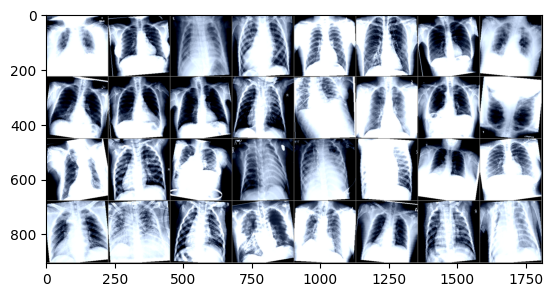

Labels: tensor([0, 1, 2, 2, 1, 0, 1, 0, 2, 1, 1, 2, 0, 1, 2, 0, 1, 2, 1, 2, 2, 2, 1, 1,
        0, 0, 2, 0, 1, 0, 2, 2])


In [15]:
#display sample images
import matplotlib.pyplot as plt
import numpy as np
import torchvision  # Import torchvision for utils

# Helper function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('Labels:', labels)



**Define the Model**

Since I'm using DenseNet-121, we can load it with pre-trained weights from ImageNet and fine-tune it for my three-class problem (COVID, Normal, Pneumonia).

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the DenseNet-121 model with pretrained weights
model = models.densenet121(pretrained=True)

# Modify the classifier for our dataset with three classes
model.classifier = nn.Linear(model.classifier.in_features, 3)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Set Up the Loss Function and Optimizer**

*   Loss Function: Use CrossEntropyLoss, since it’s suited for multi-class classification.
*   Optimizer: Adam or SGD can be a good choice. We’ll use Adam with a typical learning rate.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


**Training Loop**

The training loop will:

1.   Pass the images through the model.
2.   Calculate the loss and perform backpropagation.
3.   Update the model’s weights.

In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training parameters
epochs = 10  # Number of epochs
train_losses, test_losses = [], []

for epoch in range(epochs):
    model.train()  # Set to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        # Move images and labels to device
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)


        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate and display average training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}")


Epoch 1/10, Training Loss: 0.3298
Epoch 2/10, Training Loss: 0.2243
Epoch 3/10, Training Loss: 0.2140
Epoch 4/10, Training Loss: 0.2053
Epoch 5/10, Training Loss: 0.1813
Epoch 6/10, Training Loss: 0.1927
Epoch 7/10, Training Loss: 0.2003
Epoch 8/10, Training Loss: 0.1675
Epoch 9/10, Training Loss: 0.1543
Epoch 10/10, Training Loss: 0.1782


In [ ]:
torch.save(model.state_dict(), "/content/densenet_covid_classification.pth")

In [ ]:
# Define the path in Google Drive where you want to save the model
model_path = "/content/drive/MyDrive/densenet_covid_classification.pth"

# Save the model's state_dict to this path
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to /content/drive/MyDrive/densenet_covid_classification.pth


In [ ]:
    # Validation phase
    model.eval()  # Set to evaluation mode
    test_loss = 0.0
    correct = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get the predicted classes
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    accuracy = correct / len(test_data)
    print(f"Validation Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.4f}")

print("Training complete!")


**Recreate the Model Architecture**
To load the state_dict, you’ll need to define the same model architecture (DenseNet-121 with the modified final layer for your classes).

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Initialize the DenseNet-121 model
model = models.densenet121(pretrained=False)  # Set pretrained=False since we're loading our own weights

# Update the final layer to match the number of classes (in this case, 3)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 3)  # Assuming 3 classes: COVID, Normal, Pneumonia

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


**Load the Saved state_dict**
Now that the model architecture is defined, load the saved state_dict:

In [ ]:
# Path to the saved model
model_path = "/content/drive/MyDrive/densenet_covid_classification.pth"

# Load the state_dict into the model
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

print("Model loaded successfully and ready for evaluation!")


<ipython-input-10-dac0c48a3f48>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded successfully and ready for evaluation!


In [ ]:
# Run a test batch through the model
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move images and labels to the same device as the model
images, labels = images.to(device), labels.to(device)

# Disable gradient calculation for inference
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Display the predictions and true labels for the first batch
print("Predicted labels:", predicted)
print("True labels:", labels)


**Evaluation code**
Here’s how to proceed to evaluate the model on your test set:

1. Set up the loss criterion: The criterion (loss function) should match what you used during training. For a multi-class classification task, CrossEntropyLoss is commonly used.

2. Run the evaluation code: Use the loaded model and the test set to calculate the loss and accuracy.



In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for the test set (without augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the test dataset
test_data = datasets.ImageFolder("/content/dataset_split/test", transform=test_transform)

# Define the test data loader
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [ ]:
import torch.nn as nn

# Define the criterion (loss function), same as used in training
criterion = nn.CrossEntropyLoss()

# Set the model to evaluation mode
model.eval()

test_loss = 0.0
correct = 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Accumulate test loss
        test_loss += loss.item()

        # Get the predicted classes
        _, predicted = torch.max(outputs, 1)

        # Count correct predictions
        correct += (predicted == labels).sum().item()

# Calculate average test loss and accuracy
avg_test_loss = test_loss / len(test_loader)
accuracy = correct / len(test_data)

print(f"Validation Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.4f}")


Validation Loss: 1.2907, Accuracy: 0.3268


**automatic mixed precision (AMP) functionality**


In [ ]:
import torch
print(torch.__version__)  # Make sure you're using a compatible version (>=1.6)


2.5.0+cu121


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

# Define transformations with data augmentation for training set
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets and data loaders
train_data = datasets.ImageFolder("/content/dataset_split/train", transform=train_transform)
test_data = datasets.ImageFolder("/content/dataset_split/test", transform=test_transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)  # Reduced batch size
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

# Define model, criterion, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()  # For scaling gradients

# Early stopping and training control parameters
patience = 3  # Stop after 3 epochs without improvement
best_val_loss = float("inf")
epochs_without_improvement = 0
num_epochs = 20

# Training loop with mixed precision and early stopping
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed Precision: Using autocast to enable mixed-precision
        with torch.cuda.amp.autocast():  # Enable mixed precision
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Scaled loss and backward pass
        scaler.scale(loss).backward()  # Scale the gradients before backward
        scaler.step(optimizer)  # Apply gradients with scaling
        scaler.update()  # Update the scaler for the next iteration

        train_loss += loss.item()

    # Calculate average training loss
    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Mixed Precision during evaluation
            with torch.cuda.amp.autocast():  # Enable mixed precision for validation
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(test_loader)
    accuracy = correct / len(test_data)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Check if validation loss improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        # Save the best model
        torch.save(model.state_dict(), "/content/drive/MyDrive/densenet_covid_classification_best.pth")
        print("Validation loss improved, saving model.")
    else:
        epochs_without_improvement += 1

    # Early stopping check
    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        break

    # Update the learning rate
    scheduler.step()


<ipython-input-31-2d0193838adb>:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For scaling gradients
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-31-2d0193838adb>:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable mixed precision
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
<ipython-input-31-2d0193838adb>:83: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enabl

Epoch 1/20, Training Loss: 0.3638, Validation Loss: 0.2130, Accuracy: 0.9355
Validation loss improved, saving model.
Epoch 2/20, Training Loss: 0.2588, Validation Loss: 0.2201, Accuracy: 0.9224
Epoch 3/20, Training Loss: 0.2395, Validation Loss: 0.1497, Accuracy: 0.9508
Validation loss improved, saving model.
Epoch 4/20, Training Loss: 0.2273, Validation Loss: 0.2114, Accuracy: 0.9377
Epoch 5/20, Training Loss: 0.2058, Validation Loss: 0.1999, Accuracy: 0.9279
Epoch 6/20, Training Loss: 0.1638, Validation Loss: 0.1492, Accuracy: 0.9541
Validation loss improved, saving model.


In [5]:
import torch
from torchvision import models

# Load your model architecture (ensure this matches the model architecture you used)
model = models.densenet121(pretrained=False)
model.classifier = torch.nn.Linear(model.classifier.in_features, 3)  # Assuming 3 classes: covid, normal, pneumonia

# Load the saved model weights
model.load_state_dict(torch.load("/content/drive/MyDrive/densenet_covid_classification_best.pth"))
model.eval()  # Set to evaluation mode


<ipython-input-5-727ee57c742d>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/densenet_covid_classification_best.p

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [16]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Store all true labels and predictions
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Get predicted classes
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate overall accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed classification report
print(classification_report(all_labels, all_preds, target_names=['covid', 'normal', 'pneumonia']))


Test Accuracy: 0.9541
              precision    recall  f1-score   support

       covid       0.99      0.99      0.99       305
      normal       0.89      1.00      0.94       305
   pneumonia       1.00      0.88      0.93       305

    accuracy                           0.95       915
   macro avg       0.96      0.95      0.95       915
weighted avg       0.96      0.95      0.95       915



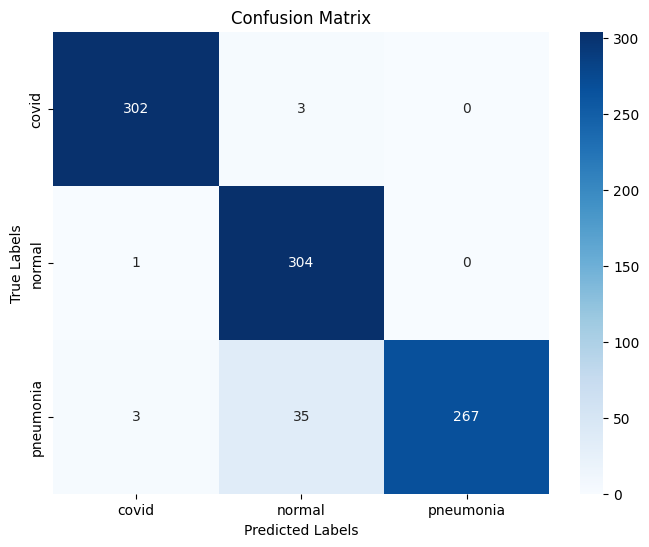

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['covid', 'normal', 'pneumonia'], yticklabels=['covid', 'normal', 'pneumonia'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


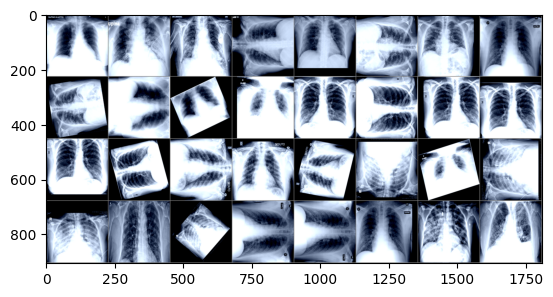

Predicted: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
True: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [18]:
import torchvision

# Display a few test images with predictions
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of test images and labels
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Make predictions
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Display images, predicted and true labels
imshow(torchvision.utils.make_grid(images.cpu()))
print("Predicted:", ' '.join(f'{predicted[j].item()}' for j in range(len(predicted))))
print("True:", ' '.join(f'{labels[j].item()}' for j in range(len(labels))))


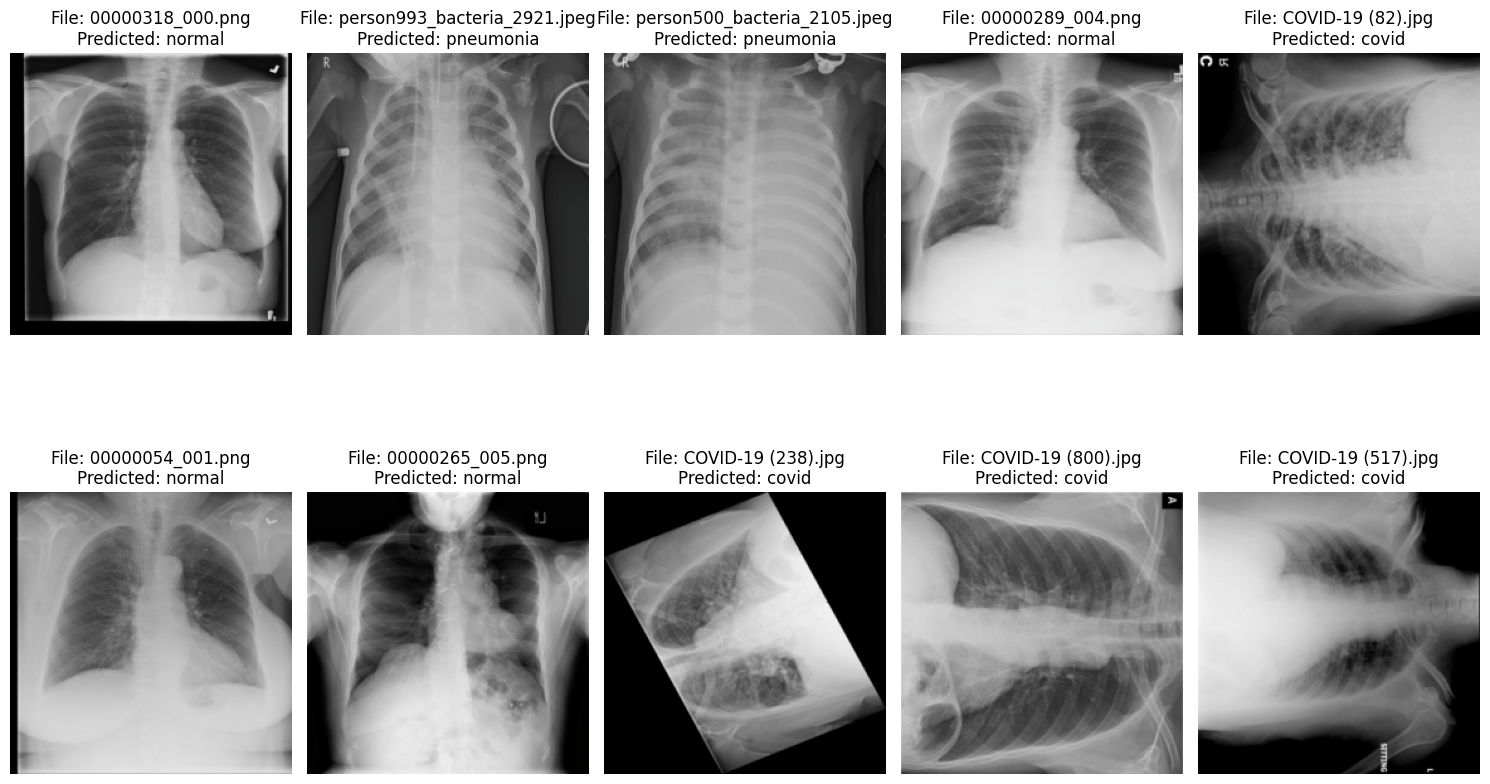

In [19]:
import torch
import random
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define transformations (as before)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the test dataset
test_data = datasets.ImageFolder("/content/dataset_split/test", transform=test_transform)

# Class names (from ImageFolder, usually folder names)
class_names = test_data.classes

# Load the saved model weights
model.load_state_dict(torch.load("/content/drive/MyDrive/densenet_covid_classification_best.pth", weights_only=True))
model.eval()

# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Select 10 random indices from the test dataset
random_indices = random.sample(range(len(test_data)), 10)

# Function to unnormalize and display an image
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip to valid range for display
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Loop over the random indices to load, predict, and display
plt.figure(figsize=(15, 10))
with torch.no_grad():
    for idx, random_index in enumerate(random_indices):
        # Load image and label
        img_path, label = test_data.samples[random_index]
        image, _ = test_data[random_index]  # Get the image tensor only
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Prediction
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

        # Display image
        plt.subplot(2, 5, idx + 1)
        imshow(image.cpu().squeeze(), title=f"File: {os.path.basename(img_path)}\nPredicted: {predicted_class}")

plt.tight_layout()
plt.show()
